In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import stochastic_load as cs

# Load data

In [2]:
importlib.reload(cs)
num_profiles = 300
num_minutes = 60

# Generate 300 stochastic load profiles
all_profiles = np.array([cs.generate_profile(num_minutes=num_minutes) for _ in range(num_profiles)])
print(all_profiles.shape)

in_sample = all_profiles[0:100,:].copy() # use first 100 profiles for in-sample
out_sample = all_profiles[100:,:].copy() # use the rest for out-of-sample analysis
print(in_sample.shape)
print(out_sample.shape)

(300, 60)
(100, 60)
(200, 60)


# Cvar

In [3]:
importlib.reload(cs)

eps=0.1
cvar_capacity, cvar_problem = cs.cvar(in_sample, eps, verbose=False)
print(f'Offered capacity for FCR-D UP: {cvar_capacity} kW')

Offered capacity for FCR-D UP: 245.89816815292517 kW


In [4]:
# In-sample reserve shortage probability
np.mean(in_sample-cvar_capacity < 0)

0.04783333333333333

# ALSO-X

In [5]:
importlib.reload(cs)

eps=0.1
also_x_capacity, also_x_problem, y = cs.also_x(in_sample, eps, verbose=False)
print(f'Offered capacity for FCR-D UP: {also_x_capacity} kW')

1.0
1.0
1.0
0.7586666666666666
0.5559999999999999
0.3998333333333333
0.27749999999999997
0.19166666666666665
0.13083333333333333
0.0885
0.11166666666666666
0.09916666666666667
0.10483333333333333
0.10216666666666667
0.10116666666666667
0.10049999999999999
0.09983333333333333
0.09999999999999999
0.10033333333333333
0.10033333333333333
0.10016666666666667
0.09999999999999999
0.09999999999999999
0.09999999999999999
Offered capacity for FCR-D UP: 266.440908155498 kW


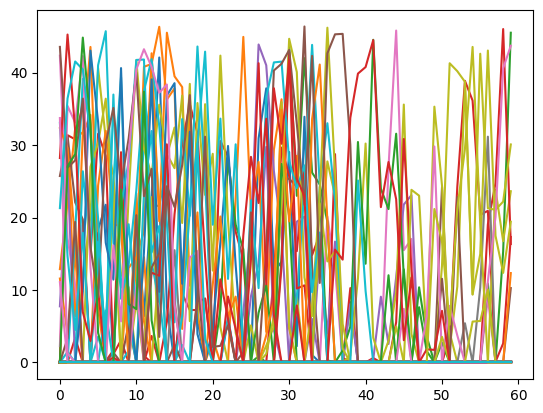

In [6]:
plt.plot(y*1e4)

In [7]:
# in-sample reserve shortage probability
np.mean(in_sample-also_x_capacity < 0)

0.10016666666666667

# 2) Out of sample analysis

In [8]:
all_out_samples = out_sample.flatten()

all_out_samples-also_x_capacity
print(np.quantile(all_out_samples-also_x_capacity, 0.1))
print(np.quantile(all_out_samples-cvar_capacity, 0.1))
print(np.mean(np.minimum(all_out_samples - cvar_capacity,0)))
print(np.mean(np.minimum(all_out_samples - also_x_capacity,0)))

# these values are positive (meaning the probability of reserve shortfall is less than 10% (if my logic is correct))

-3.1429945192329396
17.39974548333989
-0.5974935067258101
-2.217769597904753


In [9]:
# cross-check and compute the probability of reserve shortfall for both methods 
capacity_not_available_cvar = all_out_samples - cvar_capacity < 0
capacity_not_available_also_x = all_out_samples - also_x_capacity < 0
prob_unavailable_cvar = np.mean(capacity_not_available_cvar)
prob_unavailable_also_x = np.mean(capacity_not_available_also_x)
print(f'Probability of reserve shortfall for cvar: {prob_unavailable_cvar*100}%')
print(f'Probability of reserve shortfall for also-x: {prob_unavailable_also_x*100}%')

Probability of reserve shortfall for cvar: 5.008333333333334%
Probability of reserve shortfall for also-x: 10.758333333333333%


# 3) Energinet's perspective

In [10]:
epsilons = np.linspace(0, 0.2, 10)

In [11]:
# NOTE: env. 1min per iteration
results = dict()
for eps in epsilons:
    cvar_capacity, cvar_problem = cs.cvar(in_sample, eps, verbose=False)
    also_x_capacity, also_x_problem,_ = cs.also_x(in_sample, eps, verbose=False)

    all_out_samples = out_sample.flatten()

    capacity_not_available_cvar = all_out_samples - cvar_capacity < 0
    capacity_not_available_also_x = all_out_samples - also_x_capacity < 0
    prob_unavailable_cvar = np.mean(capacity_not_available_cvar)
    prob_unavailable_also_x = np.mean(capacity_not_available_also_x)
    expected_shortfall_cvar = np.mean(np.maximum(cvar_capacity - all_out_samples,0))
    expected_shortfall_also_x = np.mean(np.maximum(also_x_capacity - all_out_samples,0))
    results[eps] = {
        'cvar_capacity': cvar_capacity,
        'also_x_capacity': also_x_capacity,
        'prob_unavailable_cvar': prob_unavailable_cvar,
        'prob_unavailable_also_x': prob_unavailable_also_x,
        'expected_shortfall_cvar': expected_shortfall_cvar,
        'expected_shortfall_also_x': expected_shortfall_also_x
    }

0.0
0.983
0.7188333333333333
0.5276666666666666
0.3705
0.2608333333333333
0.17716666666666667
0.12233333333333334
0.08183333333333333
0.0555
0.036166666666666666
0.02383333333333333
0.017333333333333333
0.01983333333333333
0.021333333333333333
0.023
0.022166666666666664
0.022333333333333334
0.022166666666666664
0.022333333333333334
0.022333333333333334
0.022166666666666664
0.022166666666666664
1.0
0.983
0.7188333333333333
0.5276666666666666
0.3705
0.2608333333333333
0.17716666666666667
0.12233333333333334
0.08183333333333333
0.0555
0.036166666666666666
0.0475
0.042166666666666665
0.04483333333333333
0.042833333333333334
0.043666666666666666
0.04416666666666667
0.04416666666666667
0.04433333333333333
0.04466666666666667
0.04433333333333333
0.04433333333333333
0.04433333333333333
1.0
1.0
0.8688333333333333
0.632
0.45849999999999996
0.322
0.22699999999999998
0.15233333333333332
0.10266666666666667
0.06933333333333333
0.0475
0.057833333333333334
0.06366666666666666
0.06616666666666667
0.06

In [12]:
# Save dict
import pickle
with open('energienet_perspective_res.pkl', 'wb') as f:
    pickle.dump(results, f)

In [13]:
# Load dict
with open('energienet_perspective_res.pkl', 'rb') as f:
    loaded_res = pickle.load(f)

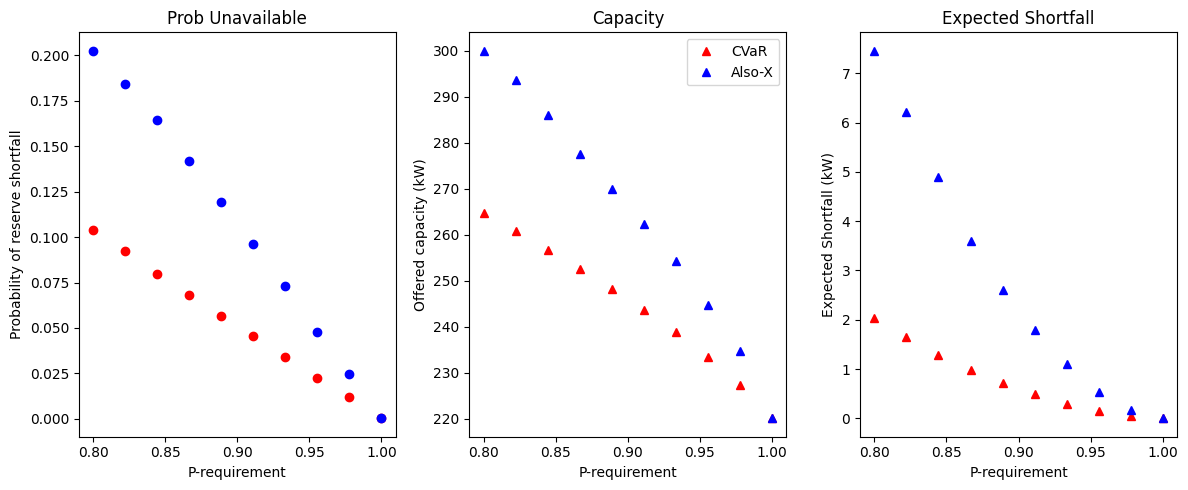

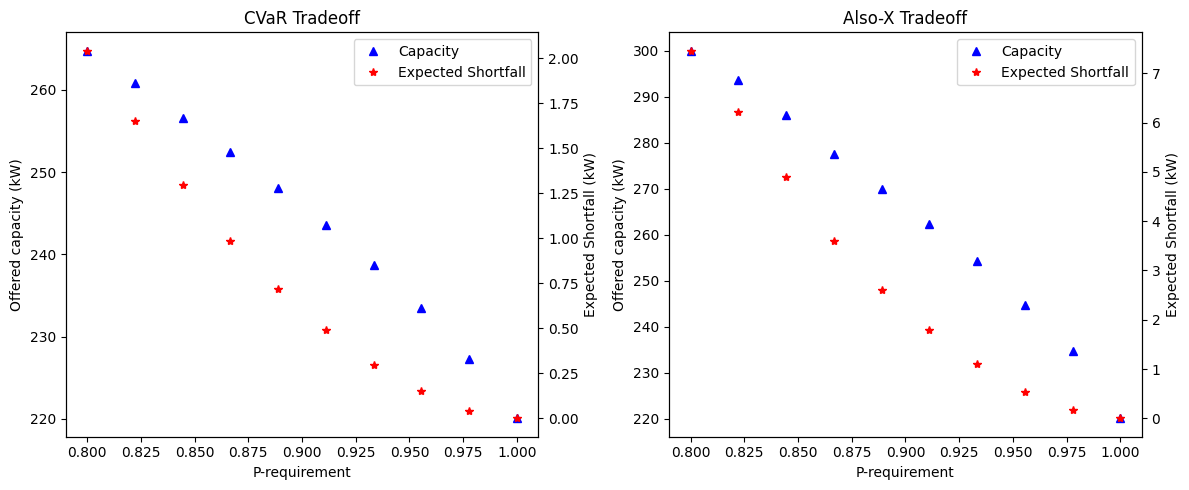

In [14]:
# Create 2x1 grid of subplots (2 columns, 1 row)
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

for key in loaded_res.keys():
    # First subplot
    ax[0].plot(1-key, loaded_res[key]['prob_unavailable_cvar'], 'ro')
    ax[0].plot(1-key, loaded_res[key]['prob_unavailable_also_x'], 'bo')

    # Second subplot
    ax[1].plot(1-key, loaded_res[key]['cvar_capacity'], 'r^')
    ax[1].plot(1-key, loaded_res[key]['also_x_capacity'], 'b^')

    # Third subplot
    ax[2].plot(1-key, loaded_res[key]['expected_shortfall_cvar'], 'r^')
    ax[2].plot(1-key, loaded_res[key]['expected_shortfall_also_x'], 'b^')

# Optionally add legends (avoid multiple duplicate entries by using unique labels or handle it once outside loop)
ax[0].set_title('Prob Unavailable')
ax[1].set_title('Capacity')
ax[2].set_title('Expected Shortfall')
ax[1].legend(['CVaR', 'Also-X'])
ax[0].set_xlabel('P-requirement')
ax[1].set_xlabel('P-requirement')
ax[2].set_xlabel('P-requirement')
ax[0].set_ylabel('Probability of reserve shortfall')
ax[1].set_ylabel('Offered capacity (kW)')   
ax[2].set_ylabel('Expected Shortfall (kW)')

plt.tight_layout()
plt.savefig('energienet_perspective.pdf')

# Also create a plot showing the tradeoff between expected shortfall and capacity (subplots for cvar ans also-x)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Create second y-axis for expected shortfall
ax2 = ax[0].twinx()
ax3 = ax[1].twinx()
for key in loaded_res.keys():
    ax[0].plot(1-key, loaded_res[key]['cvar_capacity'], 'b^', label='Capacity' if key == list(loaded_res.keys())[0] else "")
    ax2.plot(1-key, loaded_res[key]['expected_shortfall_cvar'], 'r*',label='Expected Shortfall' if key == list(loaded_res.keys())[0] else "")
    
    # Second subplot
    ax[1].plot(1-key, loaded_res[key]['also_x_capacity'], 'b^', label='Capacity' if key == list(loaded_res.keys())[0] else "")
    ax3.plot(1-key, loaded_res[key]['expected_shortfall_also_x'], 'r*',label='Expected Shortfall' if key == list(loaded_res.keys())[0] else "")

# Optionally add legends (avoid multiple duplicate entries by using unique labels or handle it once outside loop)
ax[0].set_title('CVaR Tradeoff')
ax[1].set_title('Also-X Tradeoff')
ax[0].set_xlabel('P-requirement')
ax[1].set_xlabel('P-requirement')
ax[0].set_ylabel('Offered capacity (kW)')
ax2.set_ylabel('Expected Shortfall (kW)')
ax[1].set_ylabel('Offered capacity (kW)')
ax3.set_ylabel('Expected Shortfall (kW)')
# Handle legends manually
lines1, labels1 = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[0].legend(lines1 + lines2, labels1 + labels2, loc='best')

lines3, labels3 = ax[1].get_legend_handles_labels()
lines4, labels4 = ax3.get_legend_handles_labels()
ax[1].legend(lines3 + lines4, labels3 + labels4, loc='best')
plt.tight_layout()
plt.savefig('Figures/Tradeoffs.pdf')


plt.show()